In [14]:
## Why we care derivative? this shows the change rate of the result related to the child nodes
## take input data as input and weights(which measures the implements)
import math
from pickle import NONE
import numpy as np
import matplotlib.pyplot as plt
from requests import ReadTimeout
%matplotlib inline 
##ask the meaning
## defien class named Value()
class Value:
    ## After ** define the backward， backward is a function for every operation
    ## define the __init__ function
    def __init__(self, data, _children = (), _op = '', label = '', grad = 0):
        self.data = data
    ### which pass the data to self
    ### also define previous of empty set of children, which is the previous nodes of value 
    ### stored the previous nodes in children
        self._prev = set(_children)

    ### define the _op for store the operation
        self._op = _op
    ### define the label of the value like a.label = a
        self.label = label
    ### define the grad
        self.grad = grad
        self._backward = lambda: NONE ## this function is None

    ### define represent function to return the value data as f"Value(data={self.data})
    def __repr__(self):
        return  f"Value(data={self.data})"
    ## define the plus function for adding two values combine with + 
    def __add__(self, other):
        ## for convenience setting, we should define the other and self can also handle the operation with pure numbers
        other = other if isinstance(other, Value) else Value(other) ## isinstance for check other belongs to some class
        out = Value(self.data + other.data, _children = (self, other), _op = '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + other
    ## defien the mult function for multiply two values combine with *
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,  _children =  (self, other), _op = '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    ## define a power function(__pow__), using assert to get requires int or float only
    ## ---code here---
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'Only support the int or float of power'
        out = Value(self.data ** other, (self,) ,f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out
    ## define rmul that allows other * self works this is when a.__mul__b is not work then python will try b.__mul__a
    ## ---code here---
    def __rmul__(self, other):
        return self * other
    ## define division(__truediv__)
    ## ---code here---
    def __truediv__(self, other):
        return self*other**-1
    
    ## define neg and substraction
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        return self + (-other)

    ## define the tanh function (exp(2x) - 1)/(exp(2x) + 1)
    def tanh(self):
        t = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    ## define the exp() funtion, also should add the backward fun
    def exp(self):
        out = Value(math.exp(self.data), (self,), f'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    ## define the backward function using topology sort also need to define the loop for all backward
    def backward(self):
        topo = []
        # Create an empty set named `visited`
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1
        for node in reversed(topo):
            node._backward() 

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f; L.label = 'L'



In [15]:
a = Value(2.0)
b = Value(3.0)
c = 1
print(a + c)
# print(c + a)
a / b
b / a
# a ** b
c + a
-a
a - b

Value(data=3.0)


Value(data=-1.0)

In [16]:
## visualize the structure
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [17]:
## Do the back propagation manuually and modity the dot node in draw_dot() 
# draw_dot(L)

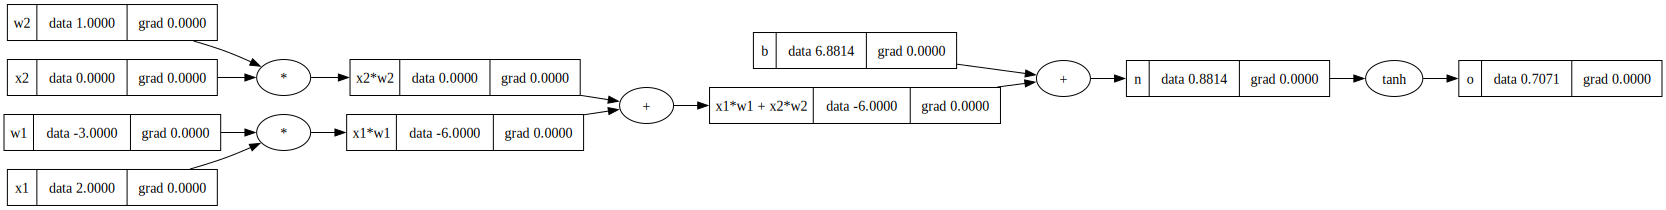

In [18]:
## using the tanh() funtion in np as the loss function
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [19]:
# o.grad = 1.0
# n.grad = 1 - o.data ** 2
# x1w1x2w2.grad = b.grad = x1w1.grad = x2w2.grad = n.grad
# x1.grad = w1.data * x1w1x2w2.grad 
# w1.grad = x1.data * x1w1x2w2.grad
# x2.grad = w2.data * x1w1x2w2.grad
# w2.grad = x2.data * x1w1x2w2.grad



In [20]:
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# x1._backward()
# x2._backward()
# w1._backward()
# w2._backward()


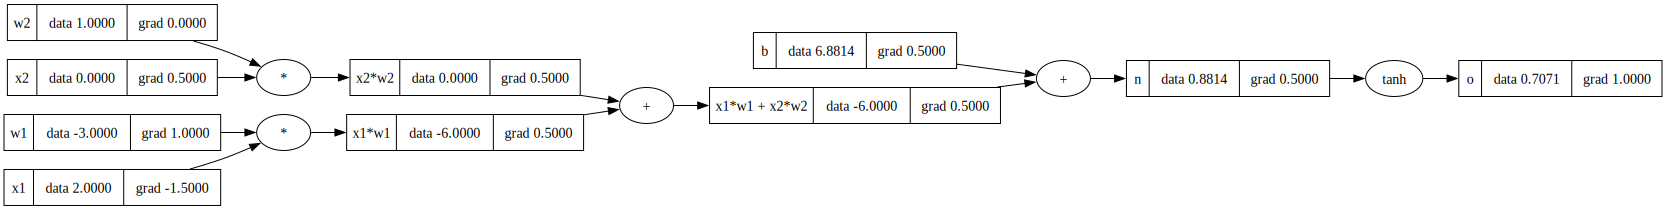

In [21]:
o.backward()
draw_dot(o)

In [22]:
# ## Using topological sort
#  # Create an empty list named `topo`
# # This list will store all nodes in topological order
# # (from earliest ancestors → to the final output node)
# topo = []
# # Create an empty set named `visited`
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)


In [23]:
# ## with the topological 
# o.grad = 1.0
# for nodes in reversed(topo):
#     nodes._backward()
# draw_dot(o)

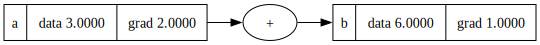

In [24]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [25]:
## using pytorch 
## torch use tensor for scalar such as value
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [26]:
import random

In [153]:
## build the NN
class Neuron:
    ## define the init with nin, indicates number of inputs inputs comes to neuron
    ## using w, b.for weight and bias and choose from random uniform
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    ## defiine __call__ , when using n = Neuron(x), python will use x.__call__()
    ## w * x + b only one bias
    ## zip() takes 2 iterators and create new iterator of tuples
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    ### define a parameters for all the weight and bias 
    def parameters(self):
        return self.w + [self.b]  
## define layer class; nout is number of output in certain layer
class Layer:
    ### define neurons for every nout for number of nin
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    ### define __call__ function output list of every neuron in neurons
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    ### define a parameters for all the weight and bias 
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    ### for define ps for every neurons and .extend them together
    ### can write two for loop in one sentence, python good for handle loop
## define MLP class: to gatther multiple layers together
class MLP:
    ### define multiple layers function, list of nouts define the size of all the layers 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts ## two list combined 
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]    
    ### put the nin and nout together. Note: the nouts is a list
    ### define the call function for layer in self.layer
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    ### define the parameters() as well
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
x = [2.0, 3.0, -1.0]
# n = Neuron(2)

In [470]:
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6949430031349867)

In [471]:
##build loss for measuring the results yout, ygt, for ys, ypred
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [495]:
for k in range(200):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

ypred

0 0.0009265257520620618
1 0.0009243421069494583
2 0.0009221684569239056
3 0.0009200047342893452
4 0.0009178508719557064
5 0.0009157068034322148
6 0.0009135724628206922
7 0.0009114477848090195
8 0.0009093327046646966
9 0.0009072271582283937
10 0.0009051310819076926
11 0.0009030444126708443
12 0.0009009670880406446
13 0.0008988990460883702
14 0.0008968402254277783
15 0.0008947905652092595
16 0.0008927500051139239
17 0.0008907184853479501
18 0.0008886959466368311
19 0.0008866823302198282
20 0.0008846775778443958
21 0.0008826816317607494
22 0.0008806944347164647
23 0.0008787159299511688
24 0.0008767460611912818
25 0.0008747847726448307
26 0.0008728320089963117
27 0.0008708877154016822
28 0.0008689518374833242
29 0.000867024321325138
30 0.0008651051134676768
31 0.000863194160903344
32 0.0008612914110716296
33 0.000859396811854456
34 0.0008575103115715432
35 0.0008556318589758094
36 0.000853761403248929
37 0.0008518988939967913
38 0.000850044281245169
39 0.0008481975154353487
40 0.0008463585

[Value(data=0.9920755187997368),
 Value(data=-0.9893219303246363),
 Value(data=-0.9877554346881192),
 Value(data=0.9826409019728306)]